In [1]:
import pandas as pd
import numpy as np
import pycountry
import pycountry_convert as pc
import matplotlib

## Step 1 of the La Art Pipeline

### Top Nations Present in National Gallery of Art in Washington, DC (EDA)

In [2]:
nationalities = pd.read_csv('../../../data_samples/LaArt/constituents_nationalities.csv')

In [3]:
artist_origin = nationalities.value_counts(normalize=True)

<Axes: xlabel='Unknown'>

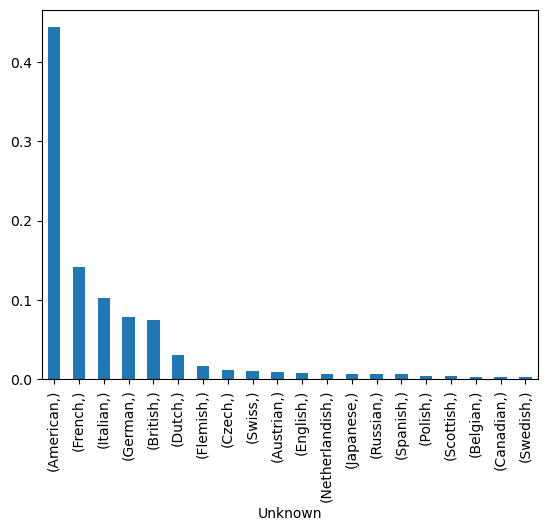

In [4]:
artist_origin[:20].plot(kind='bar')

In [5]:
artist_origin[:20]

Unknown      
American         0.443784
French           0.141439
Italian          0.102633
German           0.078396
British          0.074084
Dutch            0.030770
Flemish          0.016398
Czech            0.011563
Swiss            0.010257
Austrian         0.008885
English          0.008232
Netherlandish    0.007186
Japanese         0.006729
Russian          0.006206
Spanish          0.006010
Polish           0.004181
Scottish         0.003593
Belgian          0.003397
Canadian         0.003070
Swedish          0.002548
dtype: float64

### List of American Continent Codes for Determining which Latin American countries are present in the Gallery (Cleaning)

In [6]:
cname_alpha_2 = []
cname_alpha_3 = []
for country in pycountry.countries:
    cname_alpha_2.append(country.alpha_2)
    cname_alpha_3.append(country.alpha_3)

In [7]:
cname_alpha_2 = pd.Series(cname_alpha_2)
cname_alpha_3 = pd.Series(cname_alpha_3)

In [8]:
error_list = ['AQ', 'TF', 'EH', 'PN', 'SX', 'TL', 'UM', 'VA']
continent_names = cname_alpha_2.apply(lambda x: pc.country_alpha2_to_continent_code(x) if x not in error_list else 'non-transformable')

In [9]:
country_and_continent = pd.DataFrame([cname_alpha_2, continent_names], index= ['Country', 'Continent']).T

In [10]:
total_by_continent = country_and_continent.groupby('Continent').count()

In [11]:
remove_from_index = ['non-transformable']
total_by_continent.index = pd.Series(list(total_by_continent.index)).apply(lambda x: pc.convert_continent_code_to_continent_name(x) if x not in remove_from_index else x)

### Distribution of Countries by Continent, World Wide (data prep)

In [12]:
country_and_continent['Country Name'] = country_and_continent.Country.apply(pc.country_alpha2_to_country_name)

In [13]:
country_and_continent['Continent Name'] = country_and_continent.Continent.apply(lambda x: pc.convert_continent_code_to_continent_name(x) if x != 'non-transformable' else x)

In [17]:
# 'NA' string translates to null in many data structures, so code changed to use 'NoAm' string instead
country_and_continent['Continent'] = country_and_continent.Continent.apply(lambda x: 'NoAm' if x == 'NA' else x)

In [14]:
total_by_continent

,Country
Africa,57
Antarctica,2
Asia,53
Europe,50
North America,40
Oceania,24
South America,15
non-transformable,8


In [19]:
Latin_in_NA = ['BZ', 'CR', 'CU', 'DO', 'SV', 'GT', 'HT', 'HN', 'JM', 'MX', 'NI', 'PA', 'LC']
latin_in_NA_map = country_and_continent.Country.apply(lambda x: x in Latin_in_NA)
latin_in_SA_map = country_and_continent.Continent.apply(lambda x: x == 'SA')
latins = country_and_continent.where(latin_in_SA_map | latin_in_NA_map).dropna()
latins.name = 'Latin Countries'
latins.reset_index(inplace=True, drop=True)
latins['Country Name'] = latins.Country.apply(pc.country_alpha2_to_country_name)

### Latin American Group (Feature Engineering)

In [117]:
latins.head()

,Country,Continent,Country Name,Continent Name,Demonym
0,AR,SA,Argentina,South America,Argentinean
1,BZ,NoAm,Belize,North America,Belizean
2,BO,SA,"Bolivia, Plurinational State of",South America,Bolivian
3,BR,SA,Brazil,South America,Brazilian
4,CL,SA,Chile,South America,Chilean


In [21]:
artist_origin.index = [x[0] for x in list(artist_origin.index)]

In [22]:
latins['demonym'] = ['Argentinean', 'Belizean', 'Bolivian', 'Brazilian', 'Chilean', 'Colombian', 'Costa Rican', 'Cuban', 'Dominican', 'Ecuadorian', 'Falkland Islander', 'Guatemalan', 'Guianese', 'Guyanese', 'Honduran', 'Haitian', 'Jamaican', 'Saint Lucian', 'Mexican', 'Nicaraguan', 'Panamanian', 'Peruvian', 'Paraguayan', 'South Georgian', 'Salvadoran', 'Surinamese', 'Uruguayan', 'Venezuelan']

In [23]:
artist_origin = artist_origin.reset_index()

In [37]:
artist_origin.columns = ['demonym', 'pct_country_NGA']

In [39]:
la_geographicStatistics = pd.merge(artist_origin, latins, how='inner', on ='demonym')

In [118]:
la_geographicStatistics.head()

,Demonym,pct_country_NGA,Country,Continent,Country Name,Continent Name
0,Mexican,0.002417,MX,NoAm,Mexico,North America
1,Argentinean,0.001307,AR,SA,Argentina,South America
2,Brazilian,0.000980,BR,SA,Brazil,South America
3,Chilean,0.000392,CL,SA,Chile,South America
4,Cuban,0.000392,CU,NoAm,Cuba,North America


### Output Latin American Art data present within the NGA database (Data Prep)

In [41]:
### Important: This file is used to add geographic data to other tables in DB

In [148]:
la_geographicStatistics.to_csv('../../../data_samples/LaArt/la_geographicStatistics.csv', index=False)

In [45]:
percent_all_latin = la_geographicStatistics.pct_country_NGA.sum()
japanese_percent = artist_origin.where(artist_origin.Demonym == 'Japanese').dropna()['pct_country_NGA'][12]
print(f'The percent of all Latin American art present within the National Gallery of Art in Washington, DC is {percent_all_latin}% (rank 13), placing it right below the percent of Japanese art which is at {japanese_percent}% (rank 12)')

The percent of all Latin American art present within the National Gallery of Art in Washington, DC is 0.006402299601489514% (rank 13), placing it right below the percent of Japanese art which is at 0.00672894754034102% (rank 12)


### SQL Ran: (1) latin_art_people.sql (2) latin_art_urls.sql (3) latin_art.sql

In [170]:
latinamerican_art = pd.read_csv('../../../data_samples/LaArt/latin_art.csv', on_bad_lines='skip')

In [172]:
latinamerican_art.shape

(342, 46)

### Output data with links to view the art (the amount shrank due to only a subset being uploaded to the internet / being publically available) (Data Prep)

In [173]:
#converts the iiifurl to return the full image size
latinamerican_art['expanded_url'] = latinamerican_art.iiifthumburl.apply(lambda x: x.replace('!200,200', 'full'))

In [174]:
latinamerican_art.to_csv('../../../data_samples/LaArt/latinamerican_art.csv', index=False)

In [175]:
latinamerican_art.shape

(342, 47)

In [177]:
latinamerican_art.artists_country.value_counts()

Mexico                               204
Brazil                                37
Argentina                             27
Guatemala                             26
Chile                                 21
Venezuela, Bolivarian Republic of     16
Peru                                   3
Cuba                                   3
Colombia                               2
Uruguay                                2
Nicaragua                              1
Name: artists_country, dtype: int64